In [1]:
!pip install -q transformers datasets scikit-learn sentencepiece tqdm


In [2]:
!pip uninstall -y transformers datasets huggingface_hub fsspec sentence-transformers diffusers accelerate peft gcsfs



Found existing installation: transformers 4.57.3
Uninstalling transformers-4.57.3:
  Successfully uninstalled transformers-4.57.3
Found existing installation: datasets 4.0.0
Uninstalling datasets-4.0.0:
  Successfully uninstalled datasets-4.0.0
Found existing installation: huggingface-hub 0.36.0
Uninstalling huggingface-hub-0.36.0:
  Successfully uninstalled huggingface-hub-0.36.0
Found existing installation: fsspec 2025.3.0
Uninstalling fsspec-2025.3.0:
  Successfully uninstalled fsspec-2025.3.0
Found existing installation: sentence-transformers 5.1.2
Uninstalling sentence-transformers-5.1.2:
  Successfully uninstalled sentence-transformers-5.1.2
Found existing installation: diffusers 0.35.2
Uninstalling diffusers-0.35.2:
  Successfully uninstalled diffusers-0.35.2
Found existing installation: accelerate 1.12.0
Uninstalling accelerate-1.12.0:
  Successfully uninstalled accelerate-1.12.0
Found existing installation: peft 0.18.0
Uninstalling peft-0.18.0:
  Successfully uninstalled peft-

In [3]:
!pip install -q "transformers==4.37.0" \
               "datasets==2.16.1" \
               "huggingface_hub==0.20.3" \
               "fsspec==2023.10.0" \
               "tqdm" "scikit-learn" "sentencepiece"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 6.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.30.0 requires gcsfs!=2025.5.0,>=2023.3.0, which is not installed.
gradio 5.50.0 requires huggingface-hub<2.0,>=0.33.5, but you have huggingface-hub 0.20.3 which is incompatible

In [4]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import f1_score


In [5]:
# ==== Prompt Module ====

class PromptEmbedding(nn.Module):
    def __init__(self, prompt_len, hidden_dim, init_std=0.02):
        super().__init__()
        self.prompt = nn.Parameter(torch.randn(prompt_len, hidden_dim) * init_std)

    def forward(self, batch_size, device):
        return self.prompt.unsqueeze(0).expand(batch_size, -1, -1).to(device)


class PromptModule(nn.Module):
    def __init__(self, prompt_len, hidden_dim):
        super().__init__()
        self.prompt = PromptEmbedding(prompt_len, hidden_dim)

    def forward(self, batch_size, device):
        return self.prompt(batch_size, device)


# ==== Prompt Injector ====

def attach_prompt(model, prompt_len=30, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    hidden_dim = model.config.hidden_size
    model.prompt_module = PromptModule(prompt_len, hidden_dim).to(device)

    def forward_with_prompt(self, input_ids=None, attention_mask=None, labels=None):
        device = next(self.parameters()).device
        batch_size = input_ids.size(0)

        token_embeds = self.transformer.wte(input_ids)
        prompt_embeds = self.prompt_module(batch_size, device)

        inputs_embeds = torch.cat([prompt_embeds, token_embeds], dim=1)

        prompt_mask = torch.ones(batch_size, prompt_embeds.size(1)).to(device)
        attention_mask = torch.cat([prompt_mask, attention_mask.to(device)], dim=1)

        return self(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            labels=labels
        )

    model.forward_with_prompt = forward_with_prompt.__get__(model, model.__class__)
    return model


In [6]:
dataset = load_dataset("glue", "sst2")

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize(batch):
    return tokenizer(
        batch["sentence"],
        truncation=True,
        padding="max_length",
        max_length=64,
    )

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")

train_ds = dataset["train"]
val_ds = dataset["validation"]

print("Train size:", len(train_ds))
print("Val size:", len(val_ds))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Train size: 67349
Val size: 872


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
model.config.pad_token_id = tokenizer.eos_token_id
model.to(device)

# Freeze backbone
for p in model.parameters():
    p.requires_grad = False

# Attach prompt
attach_prompt(model, prompt_len=30, device=device)

# Enable training for prompt + classifier
for n, p in model.named_parameters():
    if "prompt_module" in n or "score" in n or "classifier" in n:
        p.requires_grad = True

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters:", trainable_params)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 24576


In [8]:
# 1. Create TensorDataset + DataLoader
from torch.utils.data import DataLoader, TensorDataset

def to_tensordataset(ds):
    return TensorDataset(
        torch.tensor(ds["input_ids"]),
        torch.tensor(ds["attention_mask"]),
        torch.tensor(ds["labels"])
    )

train_tensor = to_tensordataset(train_ds)
val_tensor = to_tensordataset(val_ds)

train_loader = DataLoader(train_tensor, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_tensor, batch_size=32)


# 2. Optimizer
optimizer = torch.optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    lr=3e-4,
)


In [9]:

# Train + Validation


# Init histories if first time
if "loss_history" not in globals():
    loss_history = []
if "acc_history" not in globals():
    acc_history = []
if "f1_history" not in globals():
    f1_history = []

num_epochs = 5

for epoch in range(num_epochs):
    print("="*30)
    print(f" Epoch {epoch} ")
    print("="*30)


    # TRAIN
    model.train()
    total_loss = 0

    for input_ids, attention_mask, labels in tqdm(train_loader, desc=f"Train {epoch}"):

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model.forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item() * input_ids.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    loss_history.append(avg_loss)
    print(f"Train Loss: {avg_loss:.4f}")


    # VALIDATION

    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            logits = model.forward(
                input_ids=input_ids,
                attention_mask=attention_mask
            ).logits

            preds = logits.argmax(dim=-1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average="weighted")

    acc_history.append(accuracy)
    f1_history.append(f1)

    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation F1: {f1:.4f}")


 Epoch 0 


Train 0:   0%|          | 0/2105 [00:00<?, ?it/s]

Train Loss: 0.5695
Validation Accuracy: 0.7615
Validation F1: 0.7570
 Epoch 1 


Train 1:   0%|          | 0/2105 [00:00<?, ?it/s]

Train Loss: 0.5075
Validation Accuracy: 0.8188
Validation F1: 0.8188
 Epoch 2 


Train 2:   0%|          | 0/2105 [00:00<?, ?it/s]

Train Loss: 0.4964
Validation Accuracy: 0.8291
Validation F1: 0.8291
 Epoch 3 


Train 3:   0%|          | 0/2105 [00:00<?, ?it/s]

Train Loss: 0.4921
Validation Accuracy: 0.8326
Validation F1: 0.8326
 Epoch 4 


Train 4:   0%|          | 0/2105 [00:00<?, ?it/s]

Train Loss: 0.4864
Validation Accuracy: 0.8200
Validation F1: 0.8184


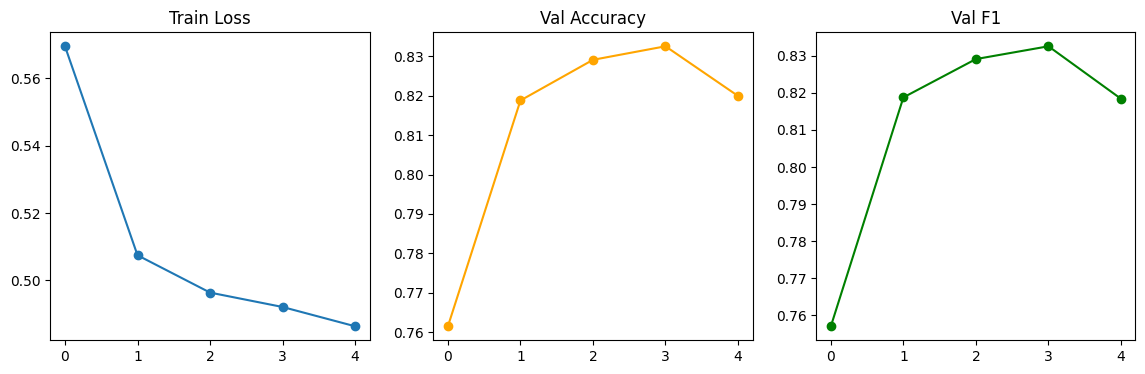

In [10]:

import matplotlib.pyplot as plt

# Plot histories so far
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(loss_history, marker='o')
plt.title("Train Loss")

plt.subplot(1, 3, 2)
plt.plot(acc_history, marker='o', color='orange')
plt.title("Val Accuracy")

plt.subplot(1, 3, 3)
plt.plot(f1_history, marker='o', color='green')
plt.title("Val F1")

plt.show()